In [28]:
import numpy as np
import importlib


In [29]:
try:
    importlib.import_module('lightgbm')
    print("LightGBM ya está instalado en el sistema.")
except ImportError:
    subprocess.run(['pip', 'install', 'lightgbm'])

LightGBM ya está instalado en el sistema.


In [30]:
!pip install skforecast
!pip install dask[dataframe]

sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x2d6d0dd4dc0>
C:\Users\34634\anaconda3\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning: unclosed file <_io.BufferedWriter name=5>
  return process_handler(cmd, _system_body)
C:\Users\34634\anaconda3\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  return process_handler(cmd, _system_body)
C:\Users\34634\anaconda3\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning: unclosed file <_io.BufferedReader name=7>
  return process_handler(cmd, _system_body)


sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x2d6ea4194c0>


In [60]:
import pandas as pd
import lightgbm as lgb
import joblib
import matplotlib.pyplot as plt
import warnings

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

from sklearn.metrics import mean_squared_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
from skforecast.datasets import fetch_dataset
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score


warnings.filterwarnings('once')

In [32]:
model = joblib.load('ML models/LightGBM_ML.pkl')

In [33]:
old_data = pd.read_csv('Fitabase Data 4.12.16-5.12.16/test_train_data.csv')
data = pd.read_csv('FitBit API Database/test_train_data_api_merged.csv')

print("Archivo : test_train_data.csv")
print(old_data)
print("\n")
print("Archivo : test_train_data_api_merged.csv")
print(data)



Archivo : test_train_data.csv
                Id                 Time   HeartRate  Intensity  Calories
0       2022484408  2016-04-12 07:21:00  101.600000          1   3.32064
1       2022484408  2016-04-12 07:22:00   87.888889          1   3.94326
2       2022484408  2016-04-12 07:23:00   58.000000          0   1.34901
3       2022484408  2016-04-12 07:24:00   58.000000          0   1.03770
4       2022484408  2016-04-12 07:25:00   56.777778          0   1.03770
...            ...                  ...         ...        ...       ...
333141  8877689391  2016-05-12 13:55:00   60.666667          0   1.33353
333142  8877689391  2016-05-12 13:56:00   61.875000          0   1.33353
333143  8877689391  2016-05-12 13:57:00   58.142857          0   1.33353
333144  8877689391  2016-05-12 13:58:00   61.200000          0   1.33353
333145  8877689391  2016-05-12 13:59:00   58.000000          0   1.33353

[333146 rows x 5 columns]


Archivo : test_train_data_api_merged.csv
           Id           

In [34]:
for column in data.columns:
    # Verificar si la columna tiene valores NaN
    if data[column].isna().any():
        # Realizar un dropna en la columna si hay valores NaN
        data = data.dropna(subset=[column])


In [35]:
#Comprobamos los valores NaN de cada columna
data.isna().sum()
data

,Id,Time,Calories,Distance,Steps,HeartRate
0,BSGSML,2024-02-15 18:13:00,1.30970,0.0,0.0,57.0
1,BSGSML,2024-02-15 18:14:00,1.44067,0.0,0.0,58.0
2,BSGSML,2024-02-15 18:15:00,1.44067,0.0,0.0,63.0
3,BSGSML,2024-02-15 18:16:00,1.30970,0.0,0.0,58.0
4,BSGSML,2024-02-15 18:17:00,1.44067,0.0,0.0,57.0
...,...,...,...,...,...,...
61227,BSGSML,2024-03-29 23:55:00,1.57248,0.0,0.0,67.0
61228,BSGSML,2024-03-29 23:56:00,1.57248,0.0,0.0,67.0
61229,BSGSML,2024-03-29 23:57:00,1.57248,0.0,0.0,67.0
61230,BSGSML,2024-03-29 23:58:00,1.57248,0.0,0.0,66.0


In [36]:
archivo_final = "FitBit API Database/test_train_data_api_merged.csv"
data.to_csv(archivo_final, index=False)

In [37]:
print(f'Número de filas con missing values: {data.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


In [38]:
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('Time')
data = data.asfreq('60S')
data = data.sort_index()
data

,Id,Calories,Distance,Steps,HeartRate
Time,,,,,
2024-02-15 18:13:00,BSGSML,1.30970,0.0,0.0,57.0
2024-02-15 18:14:00,BSGSML,1.44067,0.0,0.0,58.0
2024-02-15 18:15:00,BSGSML,1.44067,0.0,0.0,63.0
2024-02-15 18:16:00,BSGSML,1.30970,0.0,0.0,58.0
2024-02-15 18:17:00,BSGSML,1.44067,0.0,0.0,57.0
...,...,...,...,...,...
2024-03-29 23:55:00,BSGSML,1.57248,0.0,0.0,67.0
2024-03-29 23:56:00,BSGSML,1.57248,0.0,0.0,67.0
2024-03-29 23:57:00,BSGSML,1.57248,0.0,0.0,67.0


In [39]:
steps = 5
datos_train = data[:-steps]
datos_test  = data[-steps:]

print(
    f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})"
)
print(
    f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})"
)

print(f'Número de filas con missing values : (datos_train) : {datos_train.isnull().any(axis=1).mean()}')
print(f'Número de filas con missing values:  (datos_test) : {datos_test.isnull().any(axis=1).mean()}')

Fechas train : 2024-02-15 18:13:00 --- 2024-03-29 23:54:00  (n=62262)
Fechas test  : 2024-03-29 23:55:00 --- 2024-03-29 23:59:00  (n=5)
Número de filas con missing values : (datos_train) : 0.01662330153223475
Número de filas con missing values:  (datos_test) : 0.0


In [40]:
datos_train = datos_train.bfill();
print(datos_train)

                         Id  Calories  Distance  Steps  HeartRate
Time                                                             
2024-02-15 18:13:00  BSGSML   1.30970       0.0    0.0       57.0
2024-02-15 18:14:00  BSGSML   1.44067       0.0    0.0       58.0
2024-02-15 18:15:00  BSGSML   1.44067       0.0    0.0       63.0
2024-02-15 18:16:00  BSGSML   1.30970       0.0    0.0       58.0
2024-02-15 18:17:00  BSGSML   1.44067       0.0    0.0       57.0
...                     ...       ...       ...    ...        ...
2024-03-29 23:50:00  BSGSML   1.57248       0.0    0.0       65.0
2024-03-29 23:51:00  BSGSML   1.31040       0.0    0.0       63.0
2024-03-29 23:52:00  BSGSML   1.31040       0.0    0.0       63.0
2024-03-29 23:53:00  BSGSML   1.70352       0.0    0.0       66.0
2024-03-29 23:54:00  BSGSML   1.31040       0.0    0.0       65.0

[62262 rows x 5 columns]


In [41]:
datos_test= datos_test.bfill();
print(datos_test)

                         Id  Calories  Distance  Steps  HeartRate
Time                                                             
2024-03-29 23:55:00  BSGSML   1.57248       0.0    0.0       67.0
2024-03-29 23:56:00  BSGSML   1.57248       0.0    0.0       67.0
2024-03-29 23:57:00  BSGSML   1.57248       0.0    0.0       67.0
2024-03-29 23:58:00  BSGSML   1.57248       0.0    0.0       66.0
2024-03-29 23:59:00  BSGSML   1.57248       0.0    0.0       65.0


In [42]:
print(f'Número de filas con missing values : (datos_train) : {datos_train.isnull().any(axis=1).mean()}')
print(f'Número de filas con missing values:  (datos_test) : {datos_test.isnull().any(axis=1).mean()}')

Número de filas con missing values : (datos_train) : 0.0
Número de filas con missing values:  (datos_test) : 0.0


In [43]:
forecaster = ForecasterAutoreg(
                regressor = model,
                lags      = 7,
                differentiation = None
             )

forecaster.fit(y=datos_train['HeartRate'], exog=datos_train[['Calories','Steps','Distance']])
forecaster

[LightGBM] [Info] Total Bins 1301
[LightGBM] [Info] Number of data points in the train set: 62255, number of used features: 10
[LightGBM] [Info] Start training from score 65.202538


ForecasterAutoreg 
Regressor: LGBMRegressor(force_row_wise=True, learning_rate=0.2, n_estimators=200,
              num_leaves=40, objective='regression', random_state=42) 
Lags: [1 2 3 4 5 6 7] 
Transformer for y: None 
Transformer for exog: None 
Window size: 7 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['Calories', 'Steps', 'Distance'] 
Training range: [Timestamp('2024-02-15 18:13:00'), Timestamp('2024-03-29 23:54:00')] 
Training index type: DatetimeIndex 
Training index frequency: 60S 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.2, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 200, 'n_jobs': None, 'num_leaves': 40, 'objective': 'regression', 'random_state': 42, 'reg_alpha': 0.0, 'reg_lam

In [44]:
predicciones = forecaster.predict(steps=steps,  exog=datos_test[['Calories', 'Steps', 'Distance']])

In [45]:
predicciones

2024-03-29 23:55:00    66.467538
2024-03-29 23:56:00    66.867075
2024-03-29 23:57:00    67.127898
2024-03-29 23:58:00    67.348889
2024-03-29 23:59:00    67.528709
Freq: 60S, Name: pred, dtype: float64

In [46]:
datos_test['HeartRate']

Time
2024-03-29 23:55:00    67.0
2024-03-29 23:56:00    67.0
2024-03-29 23:57:00    67.0
2024-03-29 23:58:00    66.0
2024-03-29 23:59:00    65.0
Freq: 60S, Name: HeartRate, dtype: float64

In [47]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['HeartRate'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 1.706282361733194


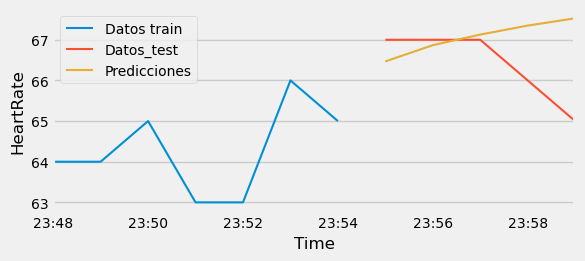

In [48]:
fig, ax = plt.subplots(figsize=(6, 2.5))

datos_train['HeartRate'].tail(7).plot(ax = ax, label = 'Datos train')
datos_test['HeartRate'].plot(ax=ax, label='Datos_test')
predicciones.plot(ax=ax, label='Predicciones')

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('HeartRate')

plt.show()

# Tunning

In [22]:
forecaster = ForecasterAutoreg(
                regressor = model,
                lags      = 12
             )

lags_grid = [10, 20]

param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['HeartRate'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        n_jobs             = 'auto',
                        verbose            = False
                  )

Number of models compared: 12.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 31121, number of used features: 10
[LightGBM] [Info] Start training from score 65.269175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 31121, number of used features: 10
[LightGBM] [Info] Start training from score 65.269175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 31121, number of used features: 10
[LightGBM] [Info] Start training from score 65.269175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Total Bins 2100
[LightGBM] [Info] Number of data points in the train set: 31111, number of used features: 20
[LightGBM] [Info] Start training from score 65.270805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Total Bins 2100
[LightGBM] [Info] Number of data points in the train set: 31111, number of used features: 20
[LightGBM] [Info] Start training from score 65.270805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Total Bins 2100
[LightGBM] [Info] Number of data points in the train set: 31111, number of used features: 20
[LightGBM] [Info] Start training from score 65.270805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 2280
[LightGBM] [Info] Number of data points in the train set: 62242, number of used features: 20
[LightGBM] [Info] Start training from score 65.203078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [23]:
resultados_grid

,lags,params,mean_squared_error,max_depth,n_estimators
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",40.294406,3,100
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",40.467348,3,100
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",40.707187,5,100
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",40.971956,5,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",41.068382,10,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",41.279778,3,500
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",41.710037,3,500
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",41.973853,10,100
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",42.695414,5,500
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",44.086206,10,500


In [49]:
archivo_final = "resultados_grid_Light.csv"
resultados_grid.to_csv(archivo_final, index=False)

In [62]:
forecaster = ForecasterAutoreg(
                regressor = model,
                lags      = 20  # mejor lags según grid search
             )

forecaster.fit(y=datos_train['HeartRate'])
predicciones = forecaster.predict(steps=steps)



[LightGBM] [Info] Total Bins 2280
[LightGBM] [Info] Number of data points in the train set: 62242, number of used features: 20
[LightGBM] [Info] Start training from score 65.203078


In [63]:
predicciones

2024-03-29 23:55:00    64.359327
2024-03-29 23:56:00    64.229115
2024-03-29 23:57:00    64.324733
2024-03-29 23:58:00    64.560475
2024-03-29 23:59:00    64.838501
Freq: 60S, Name: pred, dtype: float64

In [64]:
error_mse = mean_squared_error(
                y_true = datos_test['HeartRate'],
                y_pred = predicciones
            )

print(f"Error de test (mse) {error_mse}")

Error de test (mse) 4.781264743954894


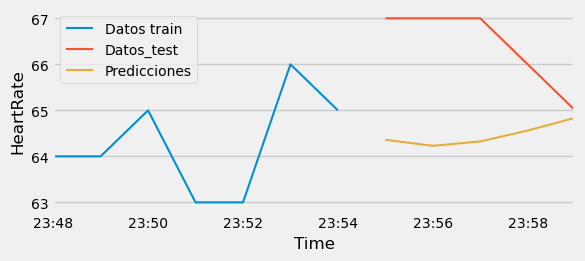

In [65]:
fig, ax = plt.subplots(figsize=(6, 2.5))

datos_train['HeartRate'].tail(7).plot(ax = ax, label = 'Datos train')
datos_test['HeartRate'].plot(ax=ax, label='Datos_test')
predicciones.plot(ax=ax, label='Predicciones')

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('HeartRate')

plt.show()